# BAF660 빅데이터와 금융자료분석 - 기말대체과제 Q1 (`prob1_bank.csv`)

`prob1_bank.csv` 데이터셋을 이용한 과제 분석 코드입니다.
EDA(`final_eda_1.py`) 결과를 바탕으로 개선된 전처리 기법을 적용합니다.

## 0. 라이브러리 임포트 및 기본 설정

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.manifold import TSNE
from collections import Counter
import os

# 시각화 설정
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# 플롯 저장 디렉토리 생성
plot_dir_q1 = 'plots/q1'
os.makedirs(plot_dir_q1, exist_ok=True)

## 1. 데이터 로드

In [39]:
# 데이터 로드
bank_data = pd.read_csv('prob1_bank.csv')

print("데이터셋 형태:", bank_data.shape)
print("\n데이터셋 정보:")
print(bank_data.info())
print("\n데이터셋 상위 5개 행:")
print(bank_data.head())

데이터셋 형태: (4521, 11)

데이터셋 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   month      4521 non-null   object
 10  y          4521 non-null   object
dtypes: int64(2), object(9)
memory usage: 388.7+ KB
None

데이터셋 상위 5개 행:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes 

## 2. 범주형 변수 전처리

### 2.1 범주형 변수 시각화 (EDA 결과 참고)

범주형 변수 (타겟 제외): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
수치형 변수: ['age', 'balance']


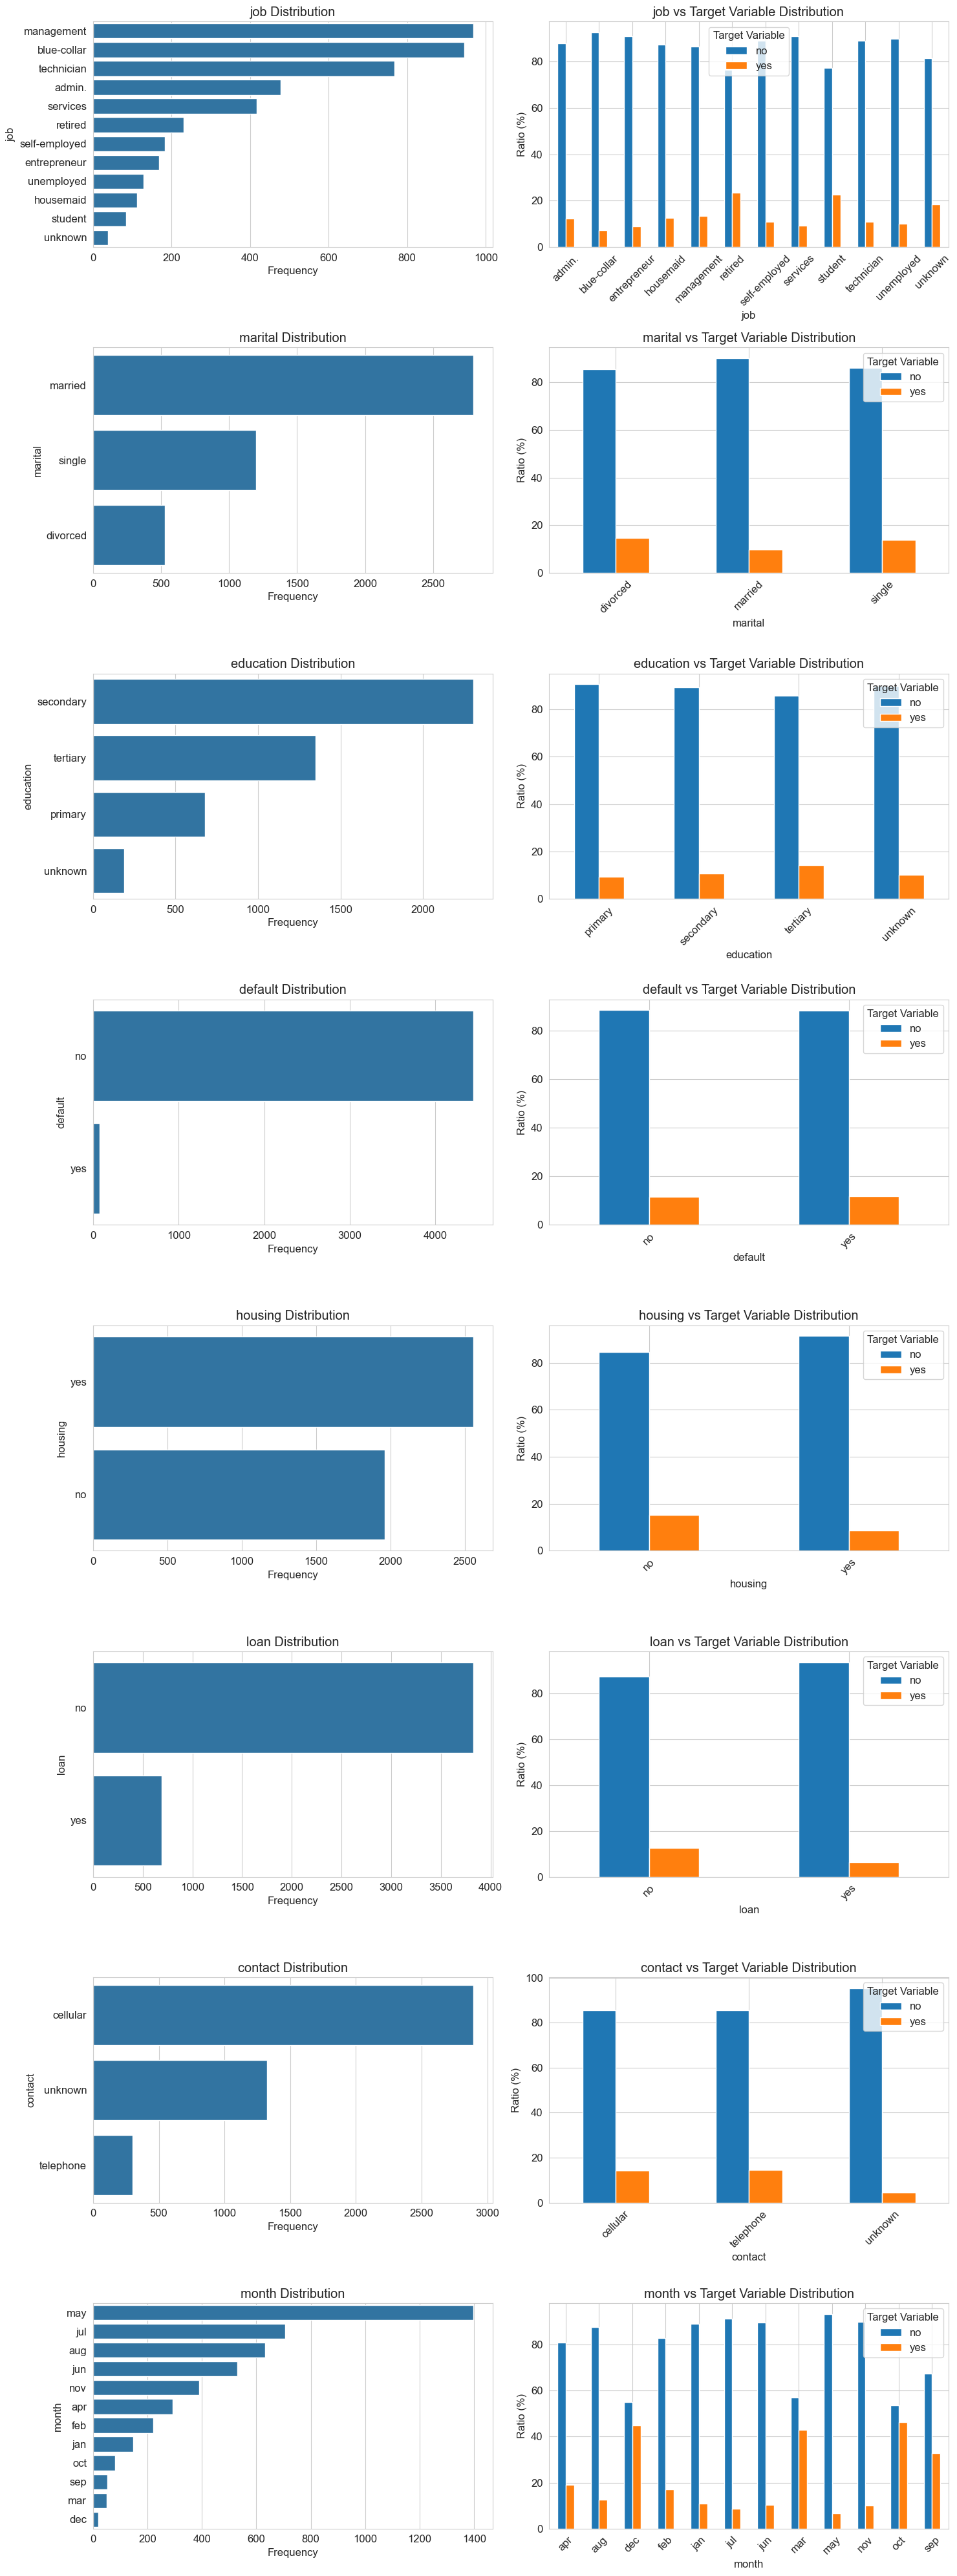

In [40]:
# 범주형/수치형 변수 식별
categorical_cols = bank_data.select_dtypes(include=['object']).columns.tolist()
target_col = 'y'
categorical_cols.remove(target_col)
numerical_cols = bank_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("범주형 변수 (타겟 제외):", categorical_cols)
print("수치형 변수:", numerical_cols)

# 범주형 변수 분포 및 타겟 변수와의 관계 시각화 (EDA와 동일, 저장)
fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(15, len(categorical_cols) * 5))

for i, col in enumerate(categorical_cols):
    # 변수 분포
    sns.countplot(y=col, data=bank_data, order=bank_data[col].value_counts().index, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} Distribution')
    axes[i, 0].set_xlabel('Frequency')
    axes[i, 0].set_ylabel(col)
    
    # 각 범주별 타겟 변수 분포
    cross_tab = pd.crosstab(bank_data[col], bank_data[target_col], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=False, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} vs Target Variable Distribution')
    axes[i, 1].set_ylabel('Ratio (%)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].legend(title='Target Variable')
    
plt.tight_layout()
plot_filename = os.path.join(plot_dir_q1, 'categorical_vs_target.png')
plt.savefig(plot_filename)
plt.show()
plt.close(fig)

### 2.2 범주형 변수 변환

EDA 결과를 바탕으로 변수별 특성을 고려하여 변환을 수행하겠습니다:
- **순서 없는 변수 (`job`, `marital`, `contact`)**: One-Hot 인코딩을 적용하고, 다중공선성 방지를 위해 `drop='first'` 옵션을 사용합니다.
- **순서 있는 변수 (`education`)**: Ordinal 인코딩 (`primary`:0, `secondary`:1, `tertiary`:2)을 적용합니다. 'unknown' 값은 NaN으로 처리 후, 다른 값들의 가중 평균으로 대체합니다.
- **이진 변수 (`default`, `housing`, `loan`)**: 0과 1로 변환하는 Label Encoding을 적용합니다.
- **순환형 변수 (`month`)**: Sin/Cos 변환을 적용하여 월별 순환성을 반영합니다.
- **목표 변수 (`y`)**: 마찬가지로 0/1 Label Encoding을 적용합니다.

In [41]:
# 변환을 위한 데이터프레임 복사
bank_processed = bank_data.copy()

# 1. Education 변환 (Ordinal + Imputation)
print("--- Education 변환 시작 ---")
education_map = {'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': np.nan}
bank_processed['education_encoded'] = bank_processed['education'].map(education_map)

# 가중 평균 계산 (NaN 제외)
known_edu = bank_processed['education_encoded'].dropna()
weights = known_edu.value_counts(normalize=True)
weighted_mean_edu = np.average(weights.index, weights=weights.values)
print(f"Education 'unknown' 대체 가중 평균값: {weighted_mean_edu:.4f}")
bank_processed['education_encoded'].fillna(weighted_mean_edu, inplace=True)
print("Education 변환 및 대체 완료.")

# 2. 이진 변수 변환 (default, housing, loan, y)
print("\n--- 이진 변수 변환 시작 ---")
binary_cols_to_encode = ['default', 'housing', 'loan', target_col]
for col in binary_cols_to_encode:
    le = LabelEncoder()
    bank_processed[f'{col}_encoded'] = le.fit_transform(bank_processed[col])
    print(f"'{col}' 변환 완료 (0: {le.classes_[0]}, 1: {le.classes_[1]})")
    # 원본 컬럼 유지 (EDA에서 필요시 참고)

# 3. Month 변환 (Cyclical: Sin/Cos)
print("\n--- Month 변환 시작 (Sin/Cos) ---")
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
bank_processed['month_num'] = bank_processed['month'].map(month_map)
bank_processed['month_sin'] = np.sin(2 * np.pi * bank_processed['month_num'] / 12)
bank_processed['month_cos'] = np.cos(2 * np.pi * bank_processed['month_num'] / 12)
print("Month Sin/Cos 변환 완료.")

# 4. 순서 없는 변수 변환 (One-Hot Encoding)
print("\n--- 순서 없는 범주형 변수 변환 시작 (One-Hot) ---")
nominal_cols = ['job', 'marital', 'contact']
bank_processed = pd.get_dummies(bank_processed, columns=nominal_cols, drop_first=True, prefix=nominal_cols)
print("One-Hot Encoding 완료.")

# 원본 범주형 컬럼 및 중간 컬럼 제거
# One-hot encoding된 컬럼('job', 'marital', 'contact')은 get_dummies에서 이미 처리됨
# 변환된 인코딩 컬럼('education_encoded', '*_encoded', 'month_sin/cos')은 유지
cols_to_drop = ['education', 'default', 'housing', 'loan', 'month', 'y', 'month_num']
# Drop columns only if they exist to avoid errors if run multiple times
cols_to_drop_existing = [col for col in cols_to_drop if col in bank_processed.columns]
bank_processed.drop(columns=cols_to_drop_existing, inplace=True)

print("\n--- 최종 변환된 데이터셋 컬럼 확인 ---")
print(bank_processed.info())

# 최종 목표 변수 컬럼명 저장
final_target_col = 'y_encoded'
final_features = bank_processed.drop(columns=[final_target_col])

# 최종 수치형/범주형(원핫 인코딩된) 컬럼 목록 정리
final_numerical_cols = list(numerical_cols) # 원본 수치형
final_numerical_cols.append('education_encoded') # 추가된 수치형
final_numerical_cols.append('month_sin')
final_numerical_cols.append('month_cos')
final_numerical_cols = [col for col in final_numerical_cols if col in final_features.columns] # 존재하는 컬럼만 필터링

final_onehot_cols = list(final_features.select_dtypes(include=['bool']).columns) # One-Hot 결과는 bool 타입일 수 있음
# 또는 float/int 타입일 수 있으므로, 더 안전하게
final_onehot_cols = [col for col in final_features.columns if any(prefix in col for prefix in [f'{c}_' for c in nominal_cols])]

print("\n최종 수치형 컬럼:", final_numerical_cols)
print("\n최종 원핫 인코딩 컬럼 수:", len(final_onehot_cols))

--- Education 변환 시작 ---
Education 'unknown' 대체 가중 평균값: 1.1551
Education 변환 및 대체 완료.

--- 이진 변수 변환 시작 ---
'default' 변환 완료 (0: no, 1: yes)
'housing' 변환 완료 (0: no, 1: yes)
'loan' 변환 완료 (0: no, 1: yes)
'y' 변환 완료 (0: no, 1: yes)

--- Month 변환 시작 (Sin/Cos) ---
Month Sin/Cos 변환 완료.

--- 순서 없는 범주형 변수 변환 시작 (One-Hot) ---
One-Hot Encoding 완료.

--- 최종 변환된 데이터셋 컬럼 확인 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                4521 non-null   int64  
 1   balance            4521 non-null   int64  
 2   education_encoded  4521 non-null   float64
 3   default_encoded    4521 non-null   int32  
 4   housing_encoded    4521 non-null   int32  
 5   loan_encoded       4521 non-null   int32  
 6   y_encoded          4521 non-null   int32  
 7   month_sin          4521 non-null   float64
 8   month_cos          4521 non-null   float64
 9 

## 3. 수치형 변수 전처리

### 3.1 수치형 변수 시각화 (EDA 결과 참고)

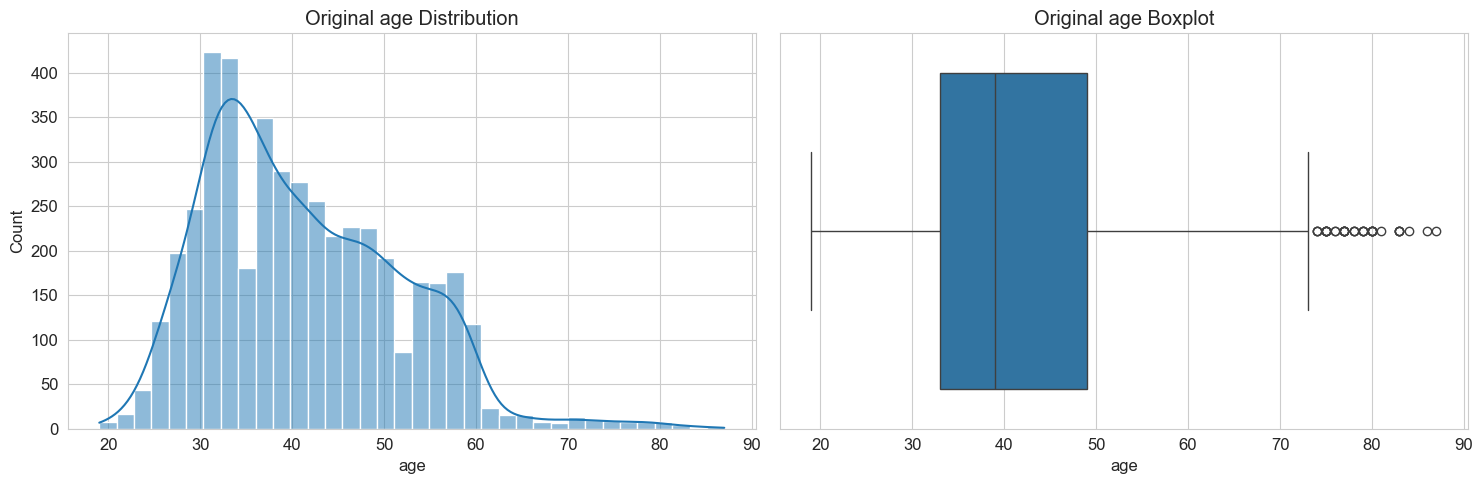

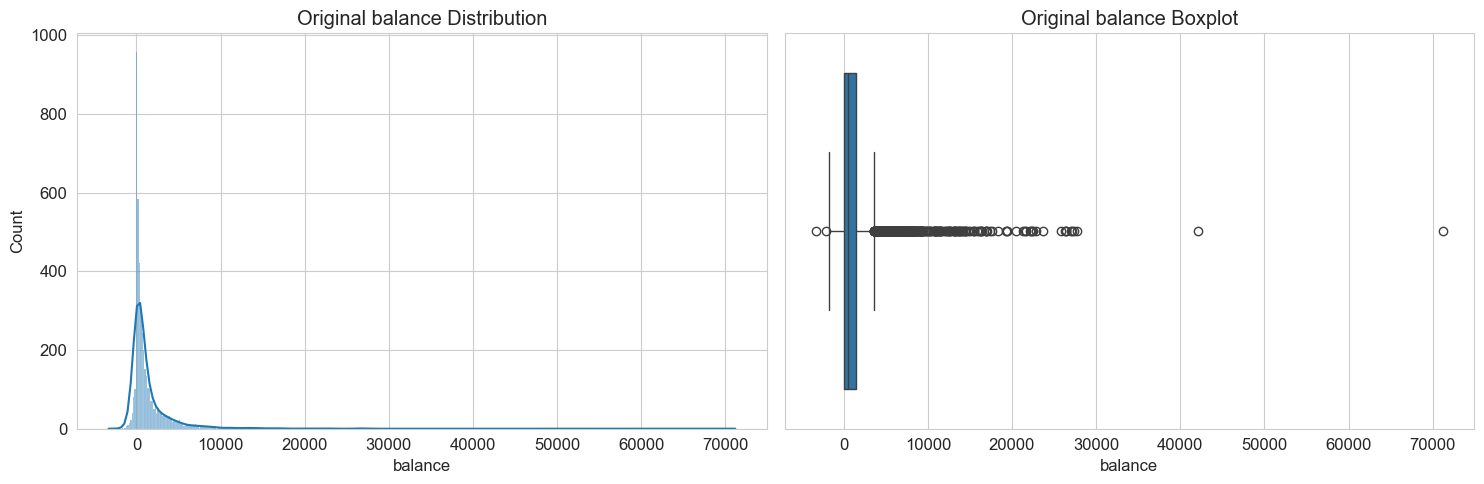

In [42]:
# 수치형 변수 분포 시각화 (원본 데이터 기준)
for i, col in enumerate(numerical_cols):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(bank_data[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Original {col} Distribution')
    sns.boxplot(x=bank_data[col], ax=axes[1])
    axes[1].set_title(f'Original {col} Boxplot')
    plt.tight_layout()
    plot_filename = os.path.join(plot_dir_q1, f'numerical_distribution_original_{col}.png')
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

### 3.2 변환 필요성 논의

- EDA 결과, 특히 `balance` 변수는 매우 높은 왜도(skewness)를 보이며 이상치의 영향을 많이 받습니다.
- `age` 변수 역시 약간의 왜도를 나타냅니다.
- 거리 기반 모델의 성능 향상 및 안정성을 위해 변수 변환을 고려하는 것이 좋습니다.
- 이상치 처리(클리핑)와 함께 스케일링 또는 변환을 적용하겠습니다.

### 3.3 수치형 변수와 목표 변수 관계 (KDE)

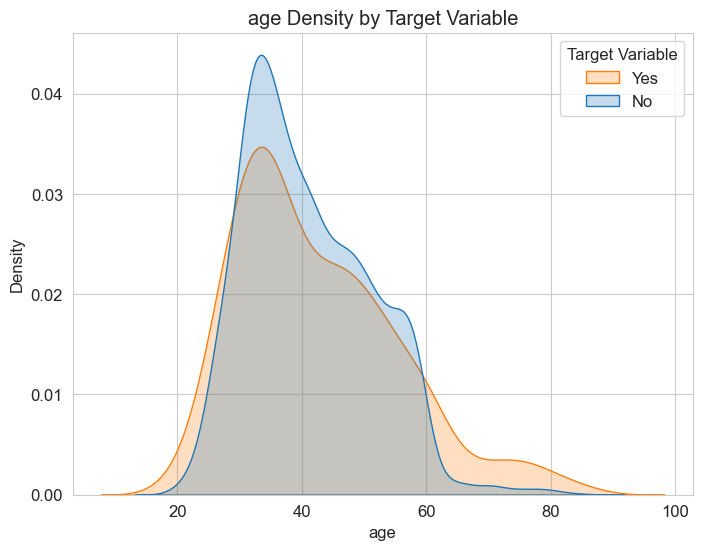

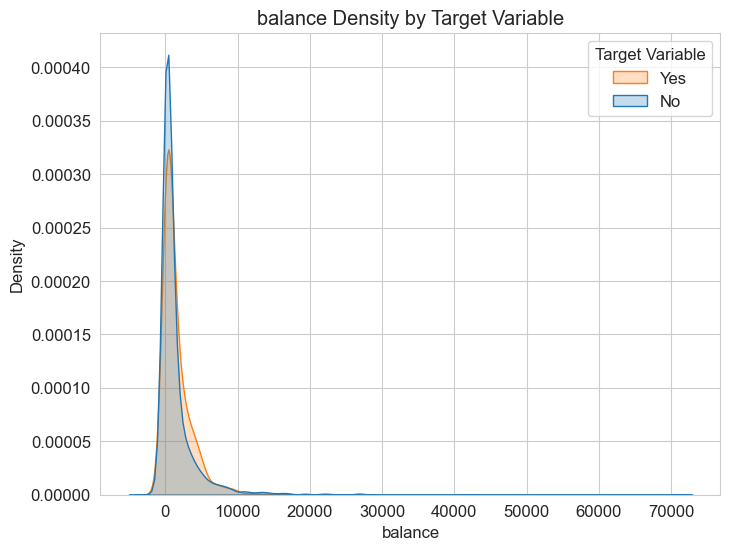

In [43]:
# 목표 변수와 주요 수치형 변수(age, balance) 관계 시각화 (KDE)
for col in ['age', 'balance']:
    fig = plt.figure(figsize=(8, 6))
    sns.kdeplot(data=bank_data, x=col, hue='y', fill=True, common_norm=False)
    plt.title(f'{col} Density by Target Variable')
    plt.xlabel(col)
    plt.legend(title='Target Variable', labels=['Yes', 'No'])
    plot_filename = os.path.join(plot_dir_q1, f'kde_vs_target_{col}.png')
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

### 3.4 특정 변수 변환 (Age: Binning, Balance: Power Transform)
- EDA 결과 및 변수 특성을 고려하여, Age는 Binning, Balance는 Power Transformation을 최종적으로 적용하기로 결정했습니다.
- 여기서는 변환 전후의 분포 변화와 Target 변수와의 관계 변화를 시각화하여 확인합니다.

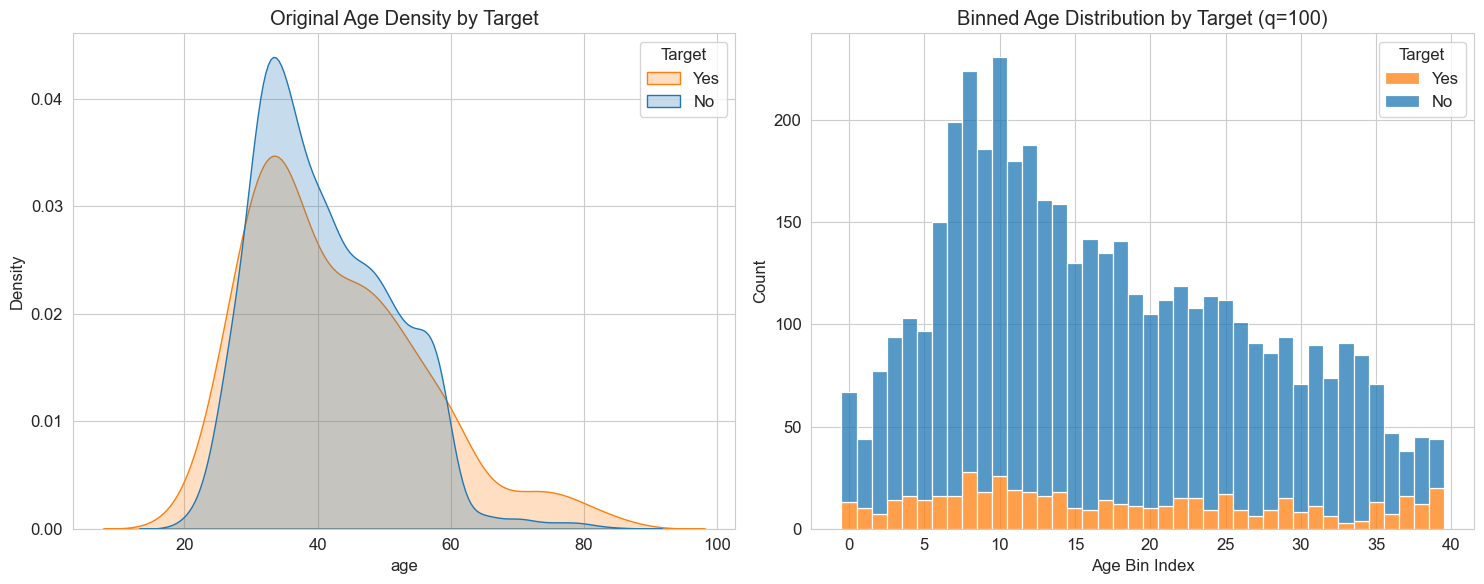

'balance' 변수를 Yeo-Johnson 변환했습니다.


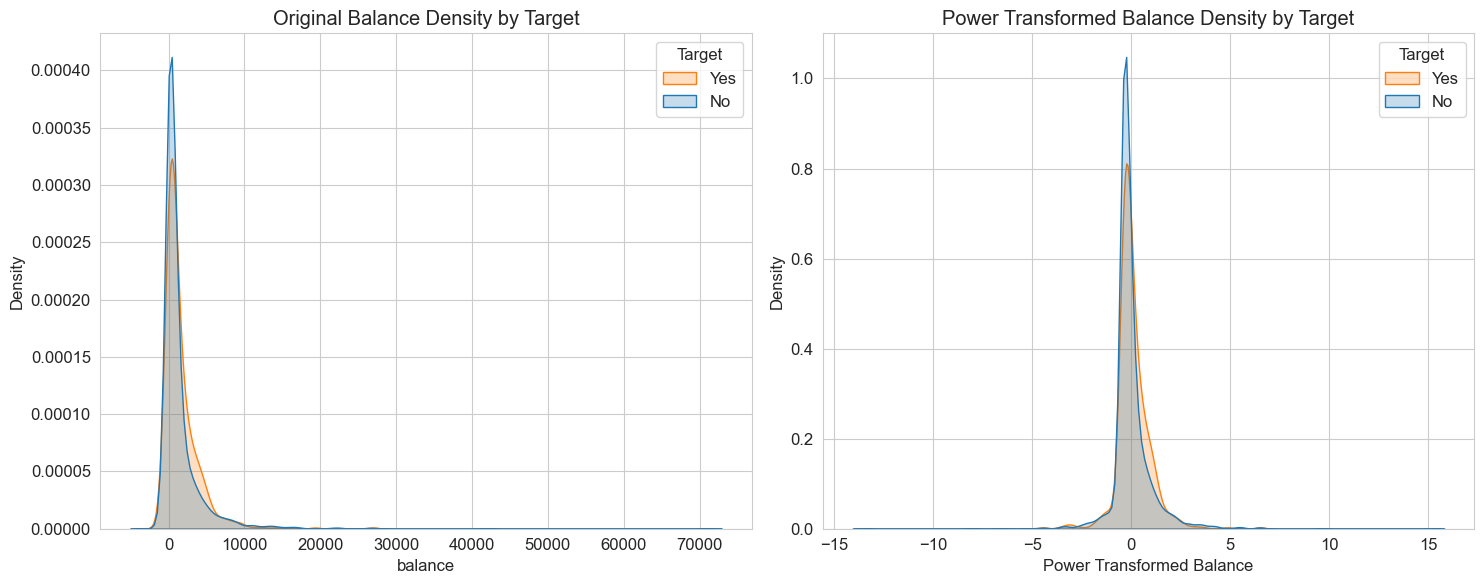

'age' 변수를 약 100개의 동일 빈도 구간으로 나누었습니다 (실제 구간 수: 40).
'balance' 변수를 Yeo-Johnson 변환했습니다.


In [44]:
# Age Binning 함수 정의 (실제 적용은 아래에서)
def apply_age_binning(df, col='age', q=100):
    df_binned = df.copy()
    try:
        df_binned[f'{col}_binned'], bin_edges = pd.qcut(df_binned[col], q=q, labels=False, duplicates='drop', retbins=True)
        print(f"'{col}' 변수를 약 {q}개의 동일 빈도 구간으로 나누었습니다 (실제 구간 수: {len(bin_edges)-1}).")
        df_binned = pd.get_dummies(df_binned, columns=[f'{col}_binned'], prefix=f'{col}_bin', drop_first=False)
    except ValueError as e:
        print(f"경고: 'age' binning 중 오류 발생 ({e}). 너무 많은 구간 요청일 수 있습니다. Binning을 건너뛰었습니다.")
        return df
    df_binned.drop(columns=[col], inplace=True)
    return df_binned

# 시각화: Age 변환 전 Target별 KDE & Binning 후 Target별 분포 비교
fig_age, axes_age = plt.subplots(1, 2, figsize=(15, 6))
# 1. 변환 전 (Original Age KDE by Target)
sns.kdeplot(data=bank_processed, x='age', hue='y_encoded', fill=True, common_norm=False, ax=axes_age[0])
axes_age[0].set_title('Original Age Density by Target')
axes_age[0].legend(title='Target', labels=['Yes', 'No'])

# 2. 변환 후 (Binned Age Histogram by Target)
# Binning 적용 (시각화용)
temp_age_binned_df = bank_processed.copy()
temp_age_binned_df['age_bin_index'] = pd.qcut(temp_age_binned_df['age'], q=100, labels=False, duplicates='drop')
# Plot histogram with hue for target variable
sns.histplot(data=temp_age_binned_df, x='age_bin_index', hue='y_encoded', multiple="stack", discrete=True, ax=axes_age[1])
axes_age[1].set_title('Binned Age Distribution by Target (q=100)')
axes_age[1].set_xlabel('Age Bin Index')
axes_age[1].legend(title='Target', labels=['Yes', 'No'])

plt.tight_layout()
plot_filename_age = os.path.join(plot_dir_q1, 'age_binning_q100_vs_target_hist.png') # 파일명 변경
plt.savefig(plot_filename_age)
plt.show()
plt.close(fig_age)

# Balance Power Transformation 함수 정의 (실제 적용은 아래에서)
def apply_balance_transformation(df, col='balance'):
    df_transformed = df.copy()
    pt = PowerTransformer(method='yeo-johnson')
    df_transformed[f'{col}_power'] = pt.fit_transform(df_transformed[[col]])
    print(f"'{col}' 변수를 Yeo-Johnson 변환했습니다.") 
    df_transformed.drop(columns=[col], inplace=True)
    return df_transformed, pt

# 시각화: Balance 변환 전/후 Target별 KDE 비교
fig_balance, axes_balance = plt.subplots(1, 2, figsize=(15, 6))
# 1. 변환 전 (Original Balance)
sns.kdeplot(data=bank_processed, x='balance', hue='y_encoded', fill=True, common_norm=False, ax=axes_balance[0])
axes_balance[0].set_title('Original Balance Density by Target')
axes_balance[0].legend(title='Target', labels=['Yes', 'No'])

# 2. 변환 후 (Power Transformed Balance)
temp_transformed_balance, _ = apply_balance_transformation(bank_processed.copy(), 'balance')
temp_transformed_balance['y_encoded'] = bank_processed['y_encoded'] # 타겟 변수 추가
sns.kdeplot(data=temp_transformed_balance, x='balance_power', hue='y_encoded', 
            fill=True, common_norm=False, ax=axes_balance[1])
axes_balance[1].set_title('Power Transformed Balance Density by Target')
axes_balance[1].set_xlabel('Power Transformed Balance')
axes_balance[1].legend(title='Target', labels=['Yes', 'No'])

plt.tight_layout()
plot_filename_balance = os.path.join(plot_dir_q1, 'kde_balance_transform_vs_target.png')
plt.savefig(plot_filename_balance)
plt.show()
plt.close(fig_balance)

# 실제 변환 적용 (bank_processed 데이터프레임 업데이트)
bank_processed = apply_age_binning(bank_processed, 'age', q=100) # q=100 적용
# apply_balance_transformation 내부에서 원본 'balance'가 drop되므로 다시 적용
bank_processed, balance_transformer = apply_balance_transformation(bank_processed, 'balance')

# 최종 컬럼 목록 재정의 (age, balance 관련 컬럼 변경 반영)
if 'age' in final_numerical_cols: final_numerical_cols.remove('age')
if 'balance' in final_numerical_cols: final_numerical_cols.remove('balance')
if 'balance_power' not in final_numerical_cols: final_numerical_cols.append('balance_power')

final_onehot_cols = [col for col in final_onehot_cols if not col.startswith('age_bin_')]
final_onehot_cols.extend([col for col in bank_processed.columns if col.startswith('age_bin_')])

### 3.5 표준화 (Standardization)
- 모든 최종 수치형 변수들에 대해 StandardScaler를 적용하여 표준화합니다.

In [45]:
print("\n--- 최종 수치형 변수 표준화 시작 ---")
scaler_final = StandardScaler()

# final_numerical_cols에 해당하는 컬럼만 선택하여 스케일링
existing_numerical_cols = [col for col in final_numerical_cols if col in bank_processed.columns]
bank_processed[existing_numerical_cols] = scaler_final.fit_transform(bank_processed[existing_numerical_cols])

print("StandardScaler 적용 완료.")
print("\n표준화 후 수치형 데이터 통계 요약:")
print(bank_processed[existing_numerical_cols].describe())


--- 최종 수치형 변수 표준화 시작 ---
StandardScaler 적용 완료.

표준화 후 수치형 데이터 통계 요약:
       education_encoded    month_sin     month_cos  balance_power
count       4.521000e+03  4521.000000  4.521000e+03   4.521000e+03
mean       -1.544146e-16     0.000000  2.200309e-17  -1.178737e-18
std         1.000111e+00     1.000111  1.000111e+00   1.000111e+00
min        -1.770675e+00    -1.658138 -8.234720e-01  -1.348783e+01
25%        -2.376934e-01    -0.838322 -6.104051e-01  -3.977729e-01
50%        -2.376934e-01    -0.018506 -6.104051e-01  -2.179281e-01
75%         1.295288e+00     0.801310 -2.829575e-02   1.763381e-01
max         1.295288e+00     1.621126  2.357233e+00   1.524098e+01


## 4. 클래스 불균형 처리 및 시각화

### 4.1 샘플링 기법 적용
- EDA에서 확인된 클래스 불균형(약 88% vs 12%) 문제를 해결하기 위해 여러 샘플링 기법을 적용해보겠습니다.
- 최종 전처리된 특성 데이터(`bank_processed`에서 타겟 변수 제외)를 사용합니다.

In [46]:
# 최종 특성(X)과 타겟(y) 분리
X = bank_processed.drop(columns=[final_target_col])
y = bank_processed[final_target_col]

print(f"\n최종 특성 데이터 형태: {X.shape}")
print(f"원본 타겟 분포: {Counter(y)}")

# 샘플링 기법 적용
sampling_techniques = {
    'Original': (X, y),
    'RandomOverSampler': RandomOverSampler(random_state=42).fit_resample(X, y),
    'SMOTE': SMOTE(random_state=42).fit_resample(X, y),
    'ADASYN': ADASYN(random_state=42).fit_resample(X, y),
    'TomekLinks': TomekLinks().fit_resample(X, y) # TomekLinks는 언더샘플링 계열
}

print("\n--- 샘플링 적용 후 데이터 형태 및 분포 --- ")
for name, (X_sampled, y_sampled) in sampling_techniques.items():
    print(f"{name}: X shape={X_sampled.shape}, y distribution={Counter(y_sampled)}")


최종 특성 데이터 형태: (4521, 62)
원본 타겟 분포: Counter({0: 4000, 1: 521})

--- 샘플링 적용 후 데이터 형태 및 분포 --- 
Original: X shape=(4521, 62), y distribution=Counter({0: 4000, 1: 521})
RandomOverSampler: X shape=(8000, 62), y distribution=Counter({0: 4000, 1: 4000})
SMOTE: X shape=(8000, 62), y distribution=Counter({0: 4000, 1: 4000})
ADASYN: X shape=(7922, 62), y distribution=Counter({0: 4000, 1: 3922})
TomekLinks: X shape=(4333, 62), y distribution=Counter({0: 3812, 1: 521})


### 4.2 t-SNE 시각화 (샘플링 결과 비교)
- 각 샘플링 기법 적용 후 데이터 분포를 2D t-SNE로 시각화하여 비교합니다.
- 오버샘플링 기법의 경우, 원본 데이터와 합성된 데이터 포인트를 구분하여 표시합니다.


--- t-SNE 시각화 시작 (샘플링 비교) --- 

Applying t-SNE for Original...


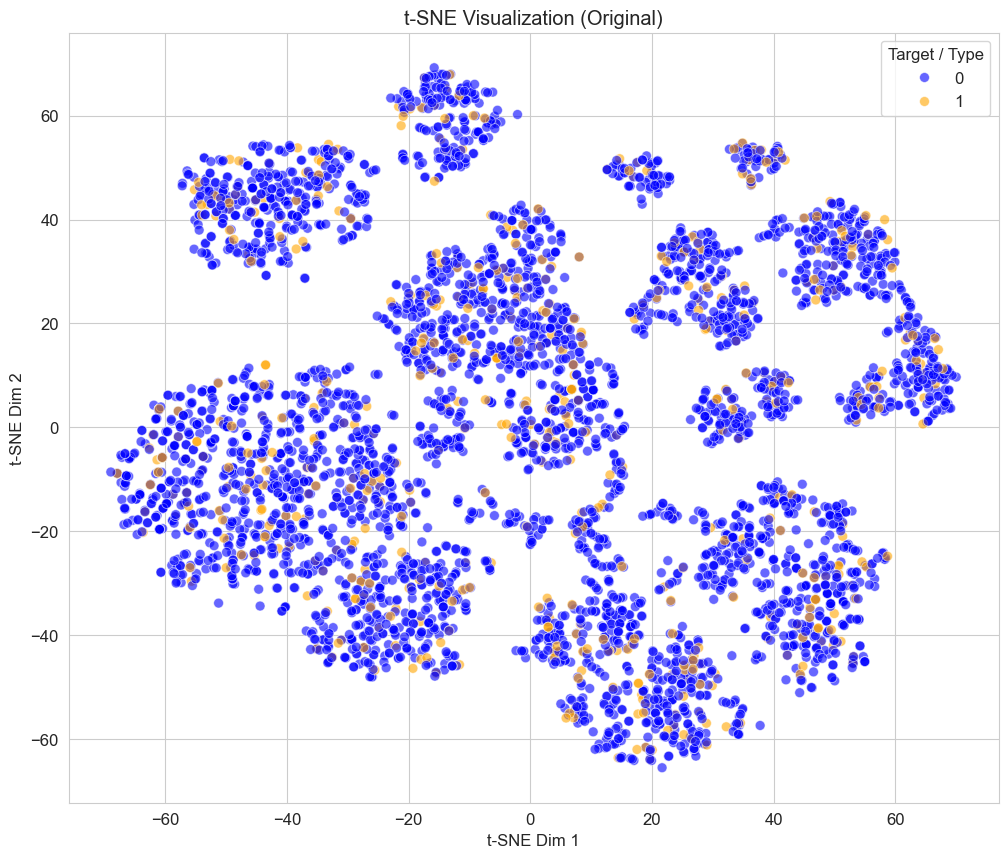


Applying t-SNE for RandomOverSampler...


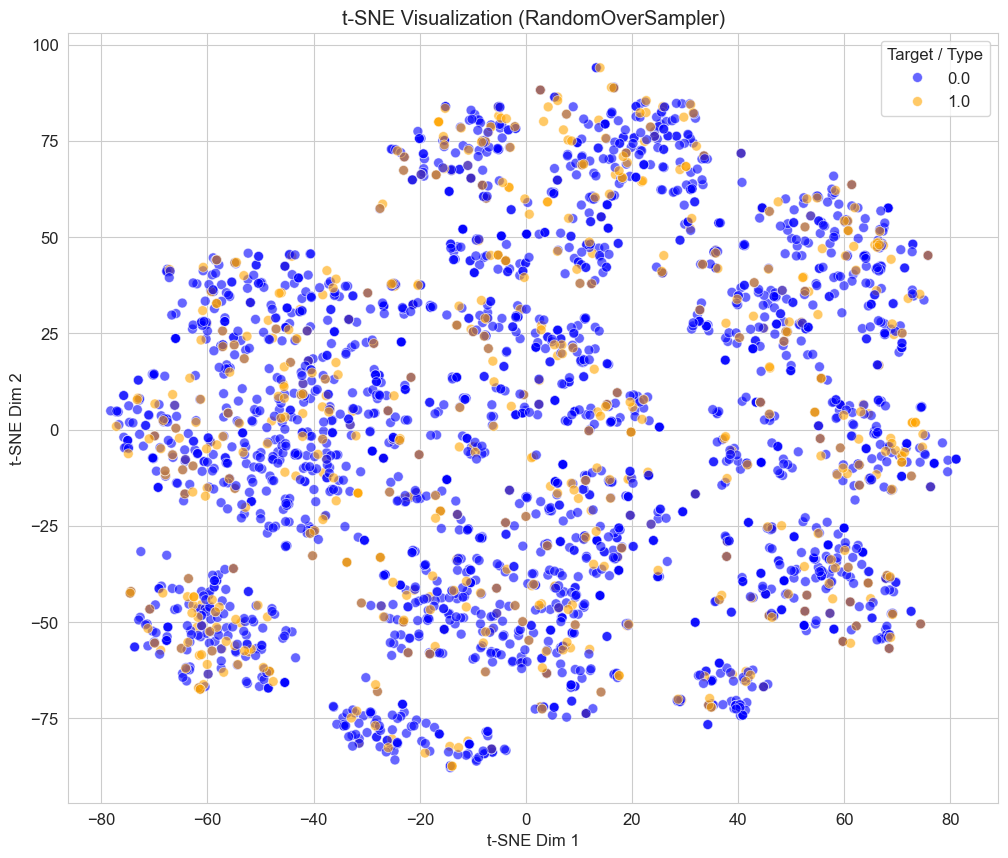


Applying t-SNE for SMOTE...


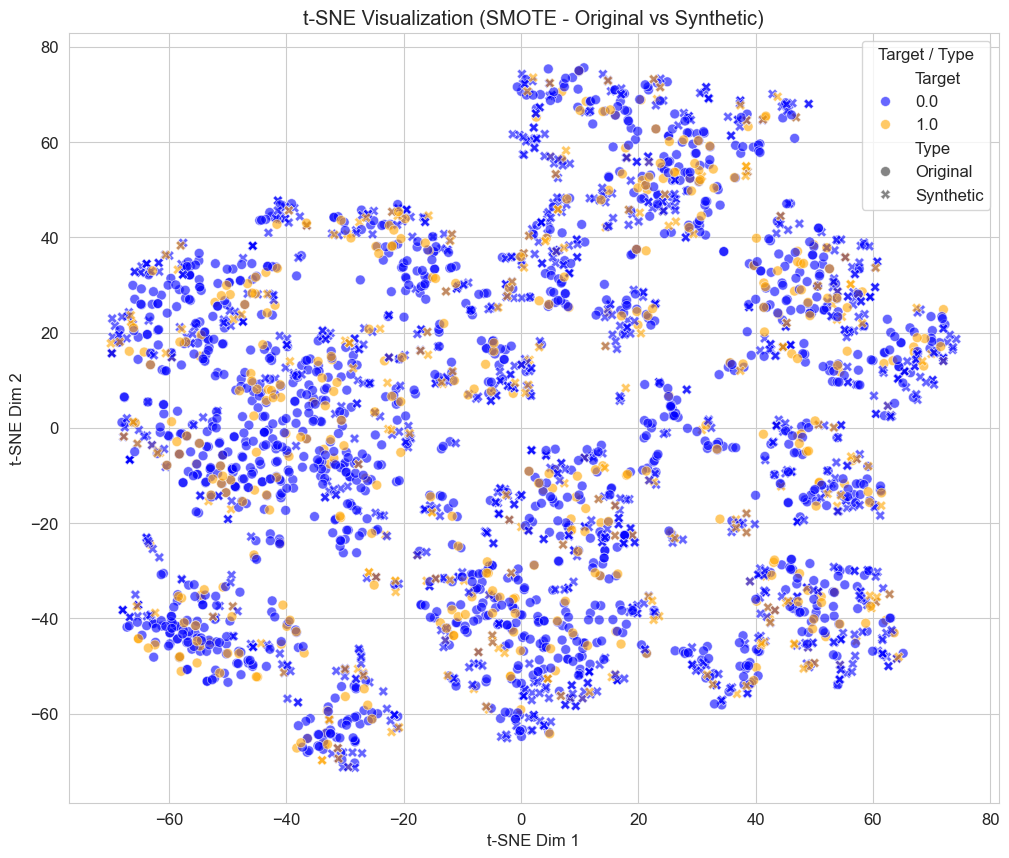


Applying t-SNE for ADASYN...


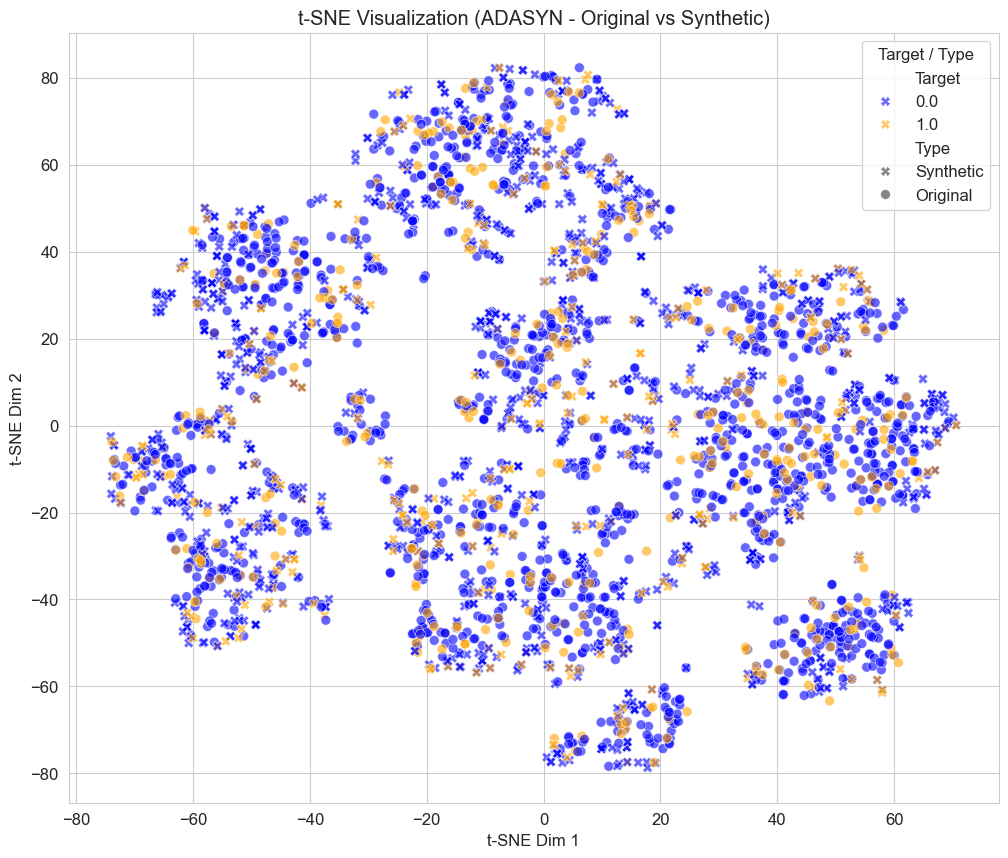


Applying t-SNE for TomekLinks...


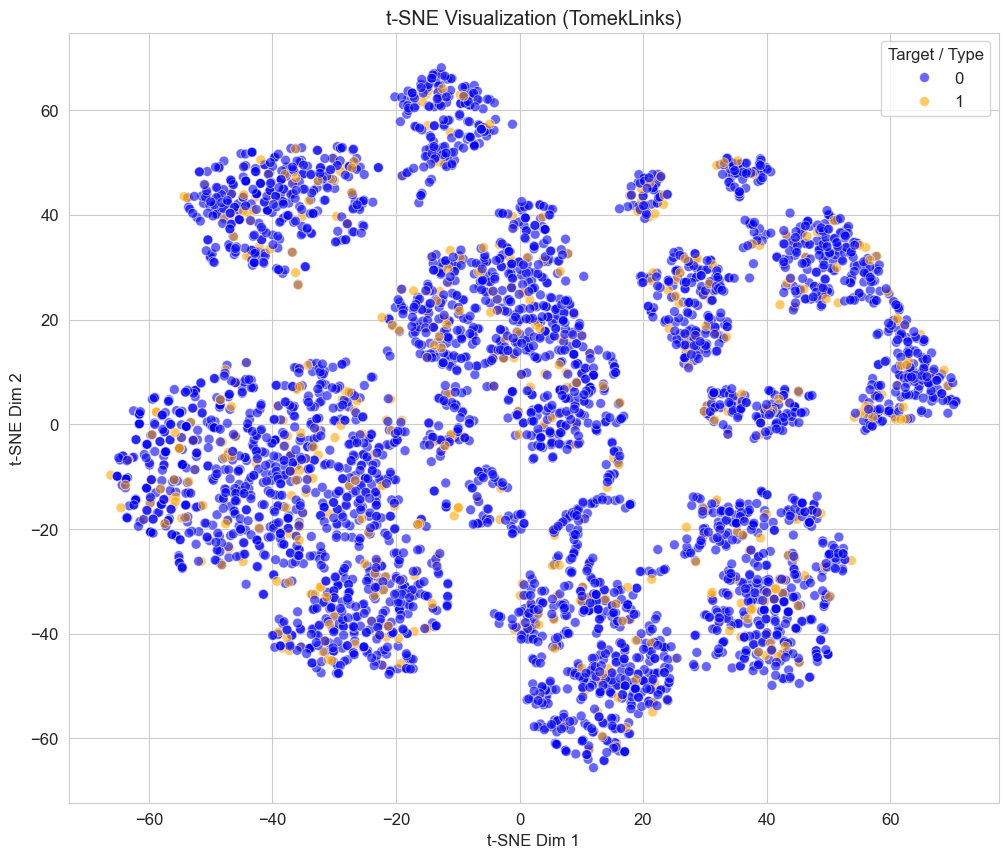


Q1 Preprocessing and Visualization Completed.


In [47]:
print("\n--- t-SNE 시각화 시작 (샘플링 비교) --- ")
n_original = len(X) # 원본 데이터 크기

for name, (X_sampled, y_sampled) in sampling_techniques.items():
    print(f"\nApplying t-SNE for {name}...")
    
    # 샘플링 (시각화를 위해)
    sample_size_tsne = min(5000, len(X_sampled))
    sample_indices = np.random.choice(len(X_sampled), sample_size_tsne, replace=False)
    X_tsne_input = X_sampled.iloc[sample_indices] if isinstance(X_sampled, pd.DataFrame) else X_sampled[sample_indices]
    y_tsne_input = y_sampled.iloc[sample_indices] if isinstance(y_sampled, pd.Series) else y_sampled[sample_indices]
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne_result = tsne.fit_transform(X_tsne_input)
    
    tsne_df = pd.DataFrame(X_tsne_result, columns=['t-SNE Dim 1', 't-SNE Dim 2'])
    tsne_df['Target'] = y_tsne_input
    tsne_df['Type'] = 'Original'
    
    # 합성 데이터 구분 (오버샘플링 경우)
    if name in ['SMOTE', 'ADASYN']:
        # sample_indices가 원본 데이터 범위를 벗어나면 합성 데이터로 간주
        # 이 방식은 인덱스가 순차적일 때 유효. resample 후 인덱스가 섞이면 다른 방식 필요.
        # fit_resample은 보통 원본 데이터 뒤에 합성 데이터를 붙이므로 이 가정이 유효할 가능성이 높음.
        original_indices_in_sample = sample_indices[sample_indices < n_original]
        synthetic_indices_in_sample = sample_indices[sample_indices >= n_original]
        
        # sample_indices 내에서의 위치를 기준으로 Type 설정
        tsne_df.loc[np.isin(sample_indices, synthetic_indices_in_sample), 'Type'] = 'Synthetic'
    elif name == 'RandomOverSampler':
         # RandomOverSampler는 인덱스를 재사용하므로 위 방식 적용 불가.
         # 임시 방편: 단순 시각화 목적이므로, 모두 Original로 표시하거나 다른 시각화 전략 필요.
         pass # 여기서는 일단 모두 Original로 처리

    # 시각화
    fig = plt.figure(figsize=(12, 10))
    if name in ['SMOTE', 'ADASYN']:
        # 원본 0, 원본 1, 합성 1 구분
        sns.scatterplot(
            x='t-SNE Dim 1', y='t-SNE Dim 2',
            hue='Target', style='Type', 
            palette={0: 'blue', 1: 'orange'}, # 0: blue, 1: orange
            markers={'Original': 'o', 'Synthetic': 'X'}, 
            s=50, alpha=0.6, data=tsne_df
        )
        plt.title(f't-SNE Visualization ({name} - Original vs Synthetic)')
    else:
        # 원본 0, 원본 1만 구분
        sns.scatterplot(
            x='t-SNE Dim 1', y='t-SNE Dim 2',
            hue='Target', palette={0: 'blue', 1: 'orange'},
            s=50, alpha=0.6, data=tsne_df
        )
        plt.title(f't-SNE Visualization ({name})')
        
    plt.legend(title='Target / Type')
    plot_filename = os.path.join(plot_dir_q1, f'tsne_sampling_{name}.png')
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

print("\nQ1 Preprocessing and Visualization Completed.") 